In [1]:
import os
os.chdir("..")
print("Current Directory:", os.getcwd())

Current Directory: d:\workspace\iscat


In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import nd2
import numpy as np
import os
import pandas as pd

In [3]:
from src.data_processing.dataset import iScatDataset
from src.data_processing.utils import Utils
import torch
DEVICE= 'cuda:10' if torch.cuda.is_available() else 'cpu'
data_path_1 = os.path.join('dataset', '2024_11_11', 'Metasurface', 'Chip_02')
data_path_2 = os.path.join('dataset', '2024_11_12', 'Metasurface', 'Chip_01')
image_paths= []
target_paths=[]
image_indicies = 12
for data_path in [data_path_1,data_path_2]:
    i,t = Utils.get_data_paths(data_path,'Brightfield',image_indicies )
    image_paths.extend(i)
    target_paths.extend(t)
image_size=256
fluo_masks_indices=[1]
seg_method = "comdet"
normalize=False
train_dataset = iScatDataset(image_paths[:-2], target_paths[:-2], preload_image=True,image_size = (image_size,image_size),apply_augmentation=True,normalize=normalize,device=DEVICE,fluo_masks_indices=fluo_masks_indices,seg_method=seg_method)

Loading images to Memory: 100%|██████████| 9/9 [00:04<00:00,  2.19it/s]


RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [5]:
MEAN = train_dataset.images.mean(dim=(0,1,2,3),keepdim=True).cpu().numpy().item()
STD = train_dataset.images.std(dim=(0,1,2,3),keepdim=True).cpu().numpy().item()

In [25]:
num='02'
path = f'dataset\\2024_11_11\\Metasurface\\Chip_02\\Metasurface {num}\\Brightfield'
z_stack_path = path+f'\\02_{num}_BF.nd2'
mask_path_Cy5 = path+'\\Captured Cy5_mask.npy'
mask_path_FITC = path+'\\Captured FITC_mask.npy'
f1_path = path+'\\Captured Cy5.tif'
f2_path = path+'\\Captured FITC.tif'
f3_path = path+'\\Captured TRITC.tif'
f1_results = path+"\\Cy5.csv"
f2_results = path+"\\FITC.csv"
f3_results = path+"\\TRITC.csv"
z_stack_image = nd2.imread(z_stack_path)
f1_img =  Image.open(f1_path)
f2_img =  Image.open(f2_path)
f3_img =  Image.open(f3_path)
import numpy as np
mask_Cy5 = np.load(mask_path_Cy5)
mask_FITC = np.load(mask_path_FITC)


In [139]:
from tifffile import imread
mean_images = [imread(path+f'\\frame_{i}_12_mean.tiff') for i in range(0,12)]
mean_images = np.stack(mean_images)

In [147]:
np.array(mask_Cy5[10,:]==1)[922:939] # Cy5 particle

array([False, False, False, False,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False])

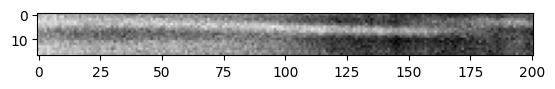

In [149]:
f=z_stack_image[:,10,922:939]
plt.imshow(f.T,cmap='gray')

In [143]:
np.array(mask_FITC[10,:]==1)[1619:1632]  # FITC particle

array([False, False, False, False,  True,  True,  True,  True,  True,
        True,  True, False, False])

In [153]:
def count_consecutive_trues(arr):
    """
    Count the lengths of consecutive True values in a NumPy array.

    Parameters:
        arr (numpy.ndarray): A 1D NumPy array of boolean values.

    Returns:
        list: A list of lengths of consecutive True sequences.
    """
    # Convert the boolean array to integers
    changes = np.diff(arr.astype(int))
    
    # Start and end indices of consecutive True sequences
    starts = np.where(changes == 1)[0] + 1
    ends = np.where(changes == -1)[0] + 1

    # Handle edge cases where the array starts or ends with True
    if arr[0]:
        starts = np.insert(starts, 0, 0)
    if arr[-1]:
        ends = np.append(ends, len(arr))

    # Calculate lengths of consecutive True sequences
    lengths = ends - starts

    return lengths.tolist()
count_consecutive_trues(np.array(mask_Cy5[10,:]==1))

[5, 1, 5, 1, 7, 1, 1, 1, 5]

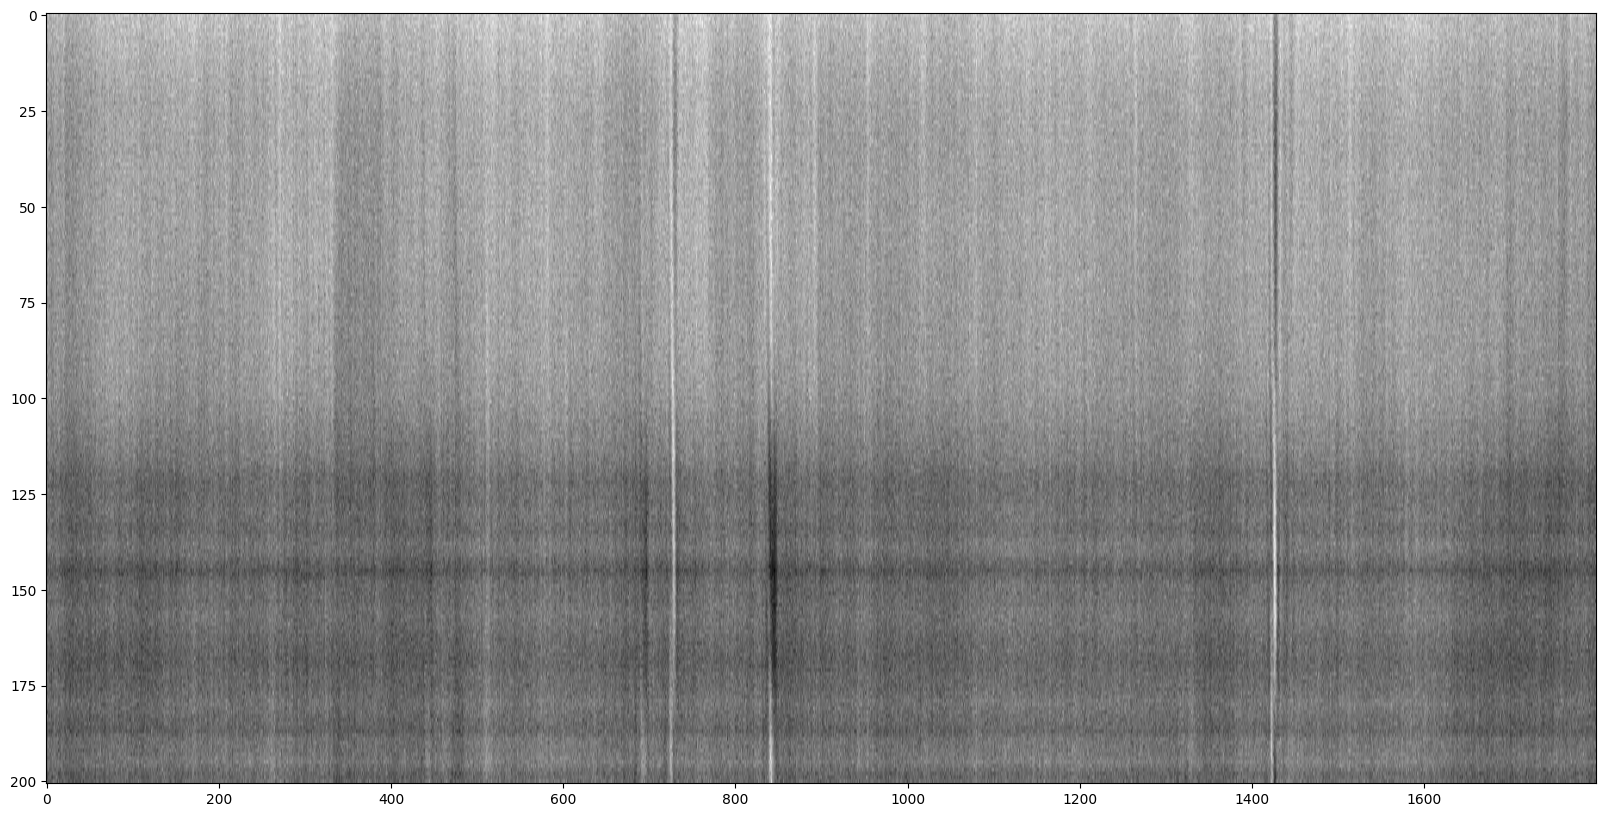

In [136]:
f=z_stack_image[:,10,:][:,200:2000]
# img_with_particle = f[:,]
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.imshow(f,cmap='gray', aspect='auto') 
plt.show()

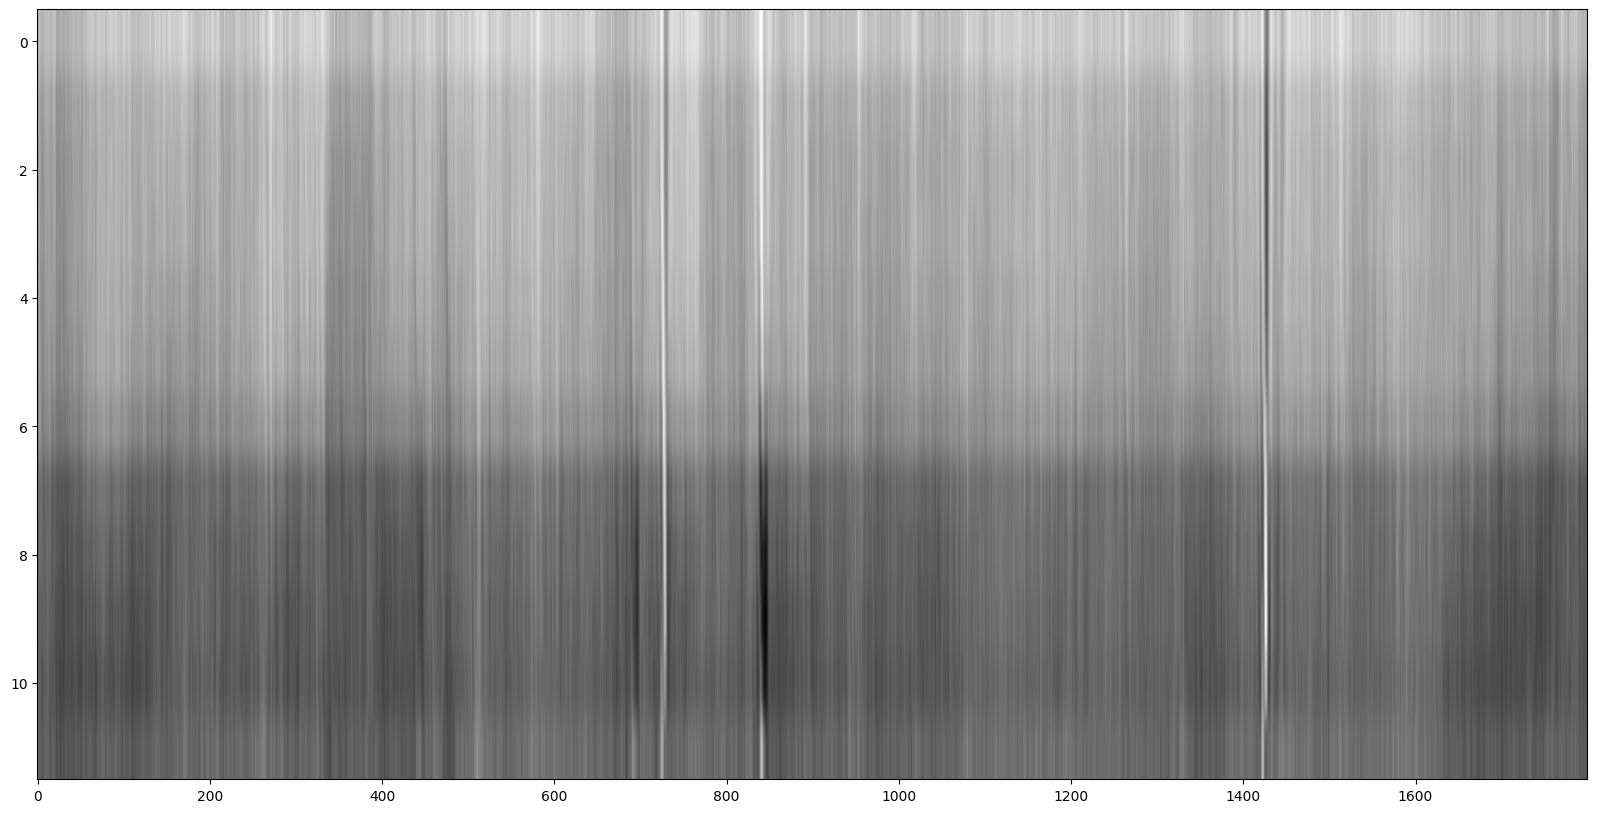

In [151]:
f=mean_images[:,10,:][:,200:2000]
# img_with_particle = f[:,]
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.imshow(f,cmap='gray', aspect='auto') 
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def display_mean_projections(image):
    """
    Compute and display the mean projections of a 3D image along specified axes.
    
    Parameters:
    - image: numpy array of shape (201, 2160, 2560)
    
    Returns:
    - mean_y: numpy array of shape (201, 2160) (mean along y-axis)
    - mean_x: numpy array of shape (201, 2560) (mean along x-axis)
    """
    # Compute mean over y-axis (axis=2)
    mean_y = np.mean(image, axis=2)
    
    # Compute mean over x-axis (axis=1)
    mean_x = np.mean(image, axis=1)      
    return mean_y, mean_x

# Example usage
# image = np.random.rand(201, 2160, 2560)  # Replace with your actual image array
# normalized_image = (z_stack_image.astype(np.float32)-MEAN)/STD
mean_y, mean_x = display_mean_projections(z_stack_image)


In [ ]:
z_stack_image.shape

In [ ]:
# Display the mean projections
plt.figure(figsize=(20, 10))

# Mean over y-axis
plt.subplot(2, 1, 1)
plt.imshow(mean_y.T[200:210,:], aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.title("Mean over Y-axis (height)")
plt.xlabel("Z-axis")
plt.ylabel("Index")

# Mean over x-axis
plt.subplot(2, 1, 2)
plt.imshow(mean_x.T[200:210,:], aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.title("Mean over X-axis (width)")
plt.xlabel("Z-axis")
plt.ylabel("Index")

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(z_stack_image[0][200:1200,200:1200],cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
def new_func(frame=0):
    chunk_1_path = path+f'\\frame_{frame}_12_mean.tiff'
    chunk_1_image = Image.open(chunk_1_path)
    chunk_1_image = np.array(chunk_1_image)
    return chunk_1_image

chunk_1_image = new_func()
plt.figure(figsize=(20, 10))
plt.imshow(chunk_1_image[200:1200,200:1200],cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.title("image 0 out of 201")
plt.imshow(z_stack_image[0][200:1200,200:1200],cmap='gray')

plt.subplot(1,2,2)
plt.title("Mean of images (0-16)")
plt.imshow(chunk_1_image[200:1200,200:1200],cmap='gray')
plt.show()

In [ ]:
diff = abs(z_stack_image[0][200:1200,200:1200]-chunk_1_image[200:1200,200:1200])
diff[diff<400]=0
diff[diff>65000]=0
plt.figure(figsize=(20, 10))
plt.imshow(diff,cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_image_histograms(image1, image2, bins=256):
    """
    Plot histograms of two images side by side in one figure with subplots.
    
    Parameters:
    - image1: numpy array, the first image (grayscale or color)
    - image2: numpy array, the second image (grayscale or color)
    - bins: int, number of bins for the histograms (default is 256)
    
    Returns:
    None
    """
    # Flatten the images to compute the histograms
    image1_flat = image1.ravel()
    image2_flat = image2.ravel()
    
    # Create the figure and subplots
    plt.figure(figsize=(12, 6))
    
    # Plot histogram for image1
    plt.subplot(1, 2, 1)
    plt.hist(image1_flat, bins=bins, color='blue', alpha=0.7)
    plt.title("image 0 out of 201")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    
    # Plot histogram for image2
    plt.subplot(1, 2, 2)
    plt.hist(image2_flat, bins=bins, color='green', alpha=0.7)
    plt.title("Mean of images (0-16)")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
plot_image_histograms(z_stack_image[0], chunk_1_image,bins=1024*4)

In [ ]:
for i in train_dataset.image_paths[0]:
    print(i)

In [ ]:
plot_image_histograms(z_stack_image[2], new_func(frame=0),bins=1024*4)